In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt



In [2]:
# Load the dataset
data= pd.read_csv('PLAB.csv')
data.head()


,collection_week,icu_staffed,masks
0,4/21/2024,273,39984
1,4/14/2024,275,43659
2,4/7/2024,275,43659
3,3/31/2024,273,39543
4,3/24/2024,273,36309


In [4]:
#print(data.dtypes)


In [3]:
# Set 'date' as index
#data.set_index('collection_week', inplace=True)
# Convert collection_week to datetime format
data['collection_week'] = pd.to_datetime(data['collection_week'])

# Add week_of_year column
data['week_of_year'] = data['collection_week'].dt.isocalendar().week

# Set collection_week as index
#df.set_index('collection_week', inplace=True)
data.head()

,collection_week,icu_staffed,masks,week_of_year
0,2024-04-21,273,39984,16
1,2024-04-14,275,43659,15
2,2024-04-07,275,43659,14
3,2024-03-31,273,39543,13
4,2024-03-24,273,36309,12


In [4]:
data['icu_staffed'] = pd.to_numeric(data['icu_staffed'], errors='coerce')
data['masks'] = pd.to_numeric(data['masks'], errors='coerce')
data['week_of_year'] = pd.to_numeric(data['week_of_year'], errors='coerce')

In [7]:
#data = data.drop('collection_week', axis=1)

In [8]:
# Splitting the data into train and test sets
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]



In [10]:
# Convert DataFrame to numpy arrays for the SARIMAX model
X_train = np.asarray(train_data[['icu_staffed']])
y_train = np.asarray(train_data['masks'])
X_test = np.asarray(test_data[['icu_staffed']])
y_test = np.asarray(test_data['masks'])

In [11]:
order = (1, 1, 1)
seasonal_order = (1, 0, 0, 12)  # Adjust the seasonal order as needed


In [12]:
model = sm.tsa.statespace.SARIMAX(y_train,
                                  exog=X_train,
                                  order=order,
                                  seasonal_order=seasonal_order,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  156
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood               -1305.315
Date:                             Thu, 26 Sep 2024   AIC                           2620.631
Time:                                     01:59:17   BIC                           2635.410
Sample:                                          0   HQIC                          2626.637
                                             - 156                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            15.2773     10.316      1.481      0.139      -4.942      35.497
ar.L1          0.6397      

In [13]:
# Making predictions
predictions = results.get_forecast(steps=len(X_test), exog=X_test)
predicted_mean = predictions.predicted_mean

In [14]:
# Calculating RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_test, predicted_mean))
mape = mean_absolute_percentage_error(y_test, predicted_mean)

In [15]:
# Printing RMSE and MAPE
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2%}')


Root Mean Squared Error (RMSE): 3081.14
Mean Absolute Percentage Error (MAPE): 5.48%


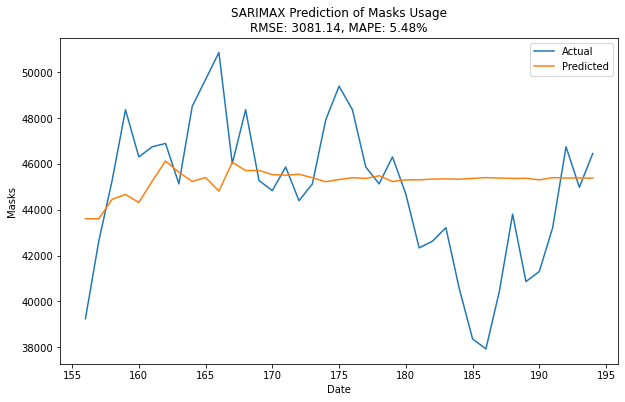

In [17]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
#plt.plot(train_data.index, train_data['masks'], label='Training Data')
plt.plot(test_data.index, test_data['masks'], label='Actual')
plt.plot(test_data.index, predicted_mean, label='Predicted')
plt.title(f'SARIMAX Prediction of Masks Usage\nRMSE: {rmse:.2f}, MAPE: {mape:.2%}')
plt.xlabel('Date')
plt.ylabel('Masks')
plt.legend()
plt.show()